In [ ]:
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DIR_ = "D:/Drive/OneDrive/Documents/MIMIC"
DIR = "D:/Workspace/MIMIC_DATA/mimic-iii-clinical-database-1.4/"

In [3]:
adm_notes = pd.read_csv(DIR + "readmission.csv", low_memory=False)

# Natural Language

In [4]:
import string
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [5]:
def clean_text(texts):
    texts = texts.fillna(' ')
    texts = texts.str.replace('\n',' ')
    texts = texts.str.replace('\r',' ')

    table = str.maketrans('', '', string.punctuation + '0123456789')
    texts = [text.lower().translate(table) for text in texts]

    return texts

In [6]:
adm_notes['TEXT'] = clean_text(adm_notes['TEXT'])

In [7]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['patient', 'date', 'admission', 'discharge', 'lastname', 'firstname', 'sex']

In [8]:
porter = PorterStemmer()

In [9]:
def tokenize_stem(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [porter.stem(word) for word in words]
    return words

# Model
## Words, Train and Test

In [10]:
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, cross_validate
from xgboost import XGBClassifier


Repartition data

In [11]:
df_train, df_test = train_test_split(adm_notes, test_size=0.3)

Subsample non-readmitted patients to match size of readmitted ones

In [12]:
rows_pos = df_train['READM_WITHIN_30'] == 1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]

df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos))], axis = 0)
df_train = df_train.sample(n = len(df_train)).reset_index(drop = True)

In [13]:
rows_pos = df_test['READM_WITHIN_30'] == 1
df_test_pos = df_test.loc[rows_pos]
df_test_neg = df_test.loc[~rows_pos]

df_test = pd.concat([df_test_pos, df_test_neg.sample(n = len(df_test_pos))], axis = 0)
df_test = df_test.sample(n = len(df_test)).reset_index(drop = True)

In [14]:
df_test, df_valid = train_test_split(df_test, test_size=0.5)

In [15]:
print(df_train.shape)
print(df_test.shape)
print(df_valid.shape)

(4254, 10)
(836, 10)
(836, 10)


Sparse Matrix with word count

In [16]:

# Assuming df_train and df_test are already defined and contain the required columns

# Vectorization
vect = CountVectorizer(lowercase=True, max_features=1000, tokenizer=tokenize_stem, token_pattern=None)

# Fit the vectorizer
vect.fit(df_train['TEXT'].values)

# Transform the text data
X_train_tf = vect.transform(df_train['TEXT'].values)
X_test_tf = vect.transform(df_test['TEXT'].values)
X_valid_tf = vect.transform(df_valid['TEXT'].values)

# Extract target variables
y_train = df_train['READM_WITHIN_30']
y_test = df_test['READM_WITHIN_30']
y_valid = df_valid['READM_WITHIN_30']
     


## XGBoost Early Stopping

In [17]:
# Define the parameter grid
grid = {
    'min_child_weight': [3, 5],
    'gamma': [0, 0.5, 1, 1.5],
    'max_depth': [3, 4, 5],
    'eta': [0.1, 0.01, 0.001]
}

# Initialize the GridSearchCV with the XGBClassifier
model_xgb = GridSearchCV(XGBClassifier(), param_grid=grid)

# Fit the model to the test data to find the best parameters
model_xgb.fit(X_test_tf, y_test)

# Access the best parameters found by the grid search
best_params = model_xgb.best_params_
print("Best parameters found by grid search:", best_params)

Best parameters found by grid search: {'eta': 0.01, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 5}


In [18]:
# Initialize the XGBClassifier with the best parameters and early stopping
model_xgb_best = XGBClassifier(
    eta=best_params['eta'],
    gamma=best_params['gamma'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    eval_metric='auc',
    early_stopping_rounds=20
)



In [19]:

# Define the evaluation set
eval_set = [(X_train_tf, y_train), (X_test_tf, y_test)]

# Initialize the XGBClassifier with parameters and early stopping
model_xgb = XGBClassifier(
    eta=0.1, 
    gamma=1, 
    max_depth=3, 
    min_child_weight=3, 
    eval_metric=['auc', 'error'], 
    early_stopping_rounds=20
)

# Fit the model with the evaluation set
model_xgb.fit(X_train_tf, y_train, eval_set=eval_set)

# Print the results of the training
results = model_xgb.evals_result()
print("Evaluation results:", results)


[0]	validation_0-auc:0.64930	validation_0-error:0.36389	validation_1-auc:0.58977	validation_1-error:0.41746
[1]	validation_0-auc:0.69250	validation_0-error:0.35731	validation_1-auc:0.61560	validation_1-error:0.40789
[2]	validation_0-auc:0.70159	validation_0-error:0.35284	validation_1-auc:0.60551	validation_1-error:0.41866
[3]	validation_0-auc:0.71163	validation_0-error:0.34203	validation_1-auc:0.60750	validation_1-error:0.41746
[4]	validation_0-auc:0.71588	validation_0-error:0.33780	validation_1-auc:0.61261	validation_1-error:0.42584
[5]	validation_0-auc:0.71777	validation_0-error:0.33992	validation_1-auc:0.61357	validation_1-error:0.42344
[6]	validation_0-auc:0.71972	validation_0-error:0.33474	validation_1-auc:0.60934	validation_1-error:0.43062
[7]	validation_0-auc:0.72474	validation_0-error:0.32981	validation_1-auc:0.62004	validation_1-error:0.41627
[8]	validation_0-auc:0.72948	validation_0-error:0.32840	validation_1-auc:0.62379	validation_1-error:0.40909
[9]	validation_0-auc:0.73335

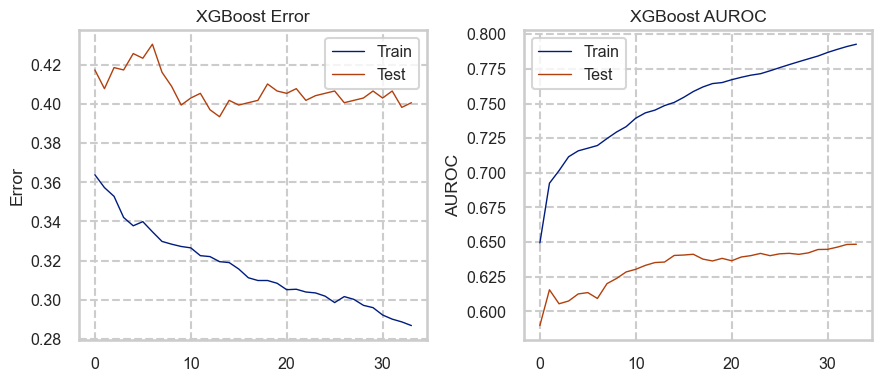

In [20]:
results = model_xgb.evals_result()

sns.set('talk', 'whitegrid', 'dark', font_scale=0.7,
        rc={"lines.linewidth": 1, 'grid.linestyle': '--'})

x_axis = range(0, len(results['validation_0']['auc']))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax[0].plot(x_axis, results['validation_0']['error'], label='Train')
ax[0].plot(x_axis, results['validation_1']['error'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost Error')
ax[0].set(ylabel='Error')

ax[1].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[1].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[1].legend()
ax[1].set_title('XGBoost AUROC')
ax[1].set(ylabel='AUROC')

fig.tight_layout()
plt.savefig('earlystopping_xgb.png')

In [21]:
y_train_preds = model_xgb.predict(X_train_tf)
y_valid_preds = model_xgb.predict(X_valid_tf)

In [22]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_preds)
fprt, tprt, thresholds = metrics.roc_curve(y_valid, y_valid_preds)

auc_train, auc_test = metrics.auc(fpr, tpr), metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_valid, y_valid_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_valid, y_valid_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_valid, y_valid_preds)

In [23]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.6805359661495063 0.6276531057112044
Accuracy	 0.6805359661495064 0.6279904306220095
Precission	 0.7 0.6068796068796068
Recall		 0.6318758815232722 0.6206030150753769


## XGBoost Regularization

In [24]:
grid = {
    'min_child_weight': [3, 5],
    'gamma': [0, 0.5, 1, 1.5],
    'max_depth': [3, 4, 5],
    'eta': [0.1,0.01,0.001],
    'reg_lambda': [0, 0.5, 0.1, 0.01]
}

model_xgb = GridSearchCV(XGBClassifier(), param_grid=grid)
model_xgb.fit(X_test_tf, y_test)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan

In [25]:
model_xgb.best_params_

{'eta': 0.01,
 'gamma': 1.5,
 'max_depth': 4,
 'min_child_weight': 5,
 'reg_lambda': 0.01}

In [26]:
model_xgb = XGBClassifier(
    eta=0.01, gamma=1.5, max_depth=5, min_child_weight=3, reg_lambda=0.1
).fit(X_train_tf, y_train)

In [27]:
y_train_preds = model_xgb.predict(X_train_tf)
y_valid_preds = model_xgb.predict(X_valid_tf)

In [28]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_preds)
fprt, tprt, thresholds = metrics.roc_curve(y_valid, y_valid_preds)

auc_train, auc_test = metrics.auc(fpr, tpr), metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_valid, y_valid_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_valid, y_valid_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_valid, y_valid_preds)

In [29]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.7698636577338975 0.6188648723067391
Accuracy	 0.7698636577338975 0.618421052631579
Precission	 0.7881526104417671 0.5938242280285035
Recall		 0.7381288199341796 0.628140703517588


## Early Stop with L2 Regularization

In [31]:
eval_set = [(X_train_tf, y_train), (X_test_tf, y_test)]

# Initialize the XGBClassifier with parameters and early stopping
model_xgb = XGBClassifier(
    eta=0.01, 
    gamma=1.5, 
    max_depth=5, 
    min_child_weight=3, 
    reg_lambda=0.1, 
    eval_metric=['auc', 'error'], 
    early_stopping_rounds=20
)

# Fit the model with the evaluation set
model_xgb.fit(X_train_tf, y_train, eval_set=eval_set)

# Print the results of the training
results = model_xgb.evals_result()
print("Evaluation results:", results)

[0]	validation_0-auc:0.71422	validation_0-error:0.33874	validation_1-auc:0.59334	validation_1-error:0.43780
[1]	validation_0-auc:0.72402	validation_0-error:0.32205	validation_1-auc:0.59997	validation_1-error:0.42344
[2]	validation_0-auc:0.72428	validation_0-error:0.32276	validation_1-auc:0.59942	validation_1-error:0.42225
[3]	validation_0-auc:0.73057	validation_0-error:0.32087	validation_1-auc:0.59849	validation_1-error:0.41746
[4]	validation_0-auc:0.72907	validation_0-error:0.32346	validation_1-auc:0.59962	validation_1-error:0.41627
[5]	validation_0-auc:0.73313	validation_0-error:0.32228	validation_1-auc:0.59949	validation_1-error:0.41627
[6]	validation_0-auc:0.73288	validation_0-error:0.32064	validation_1-auc:0.60105	validation_1-error:0.42105
[7]	validation_0-auc:0.73609	validation_0-error:0.31406	validation_1-auc:0.60018	validation_1-error:0.41866
[8]	validation_0-auc:0.73588	validation_0-error:0.31594	validation_1-auc:0.60250	validation_1-error:0.41627
[9]	validation_0-auc:0.73747

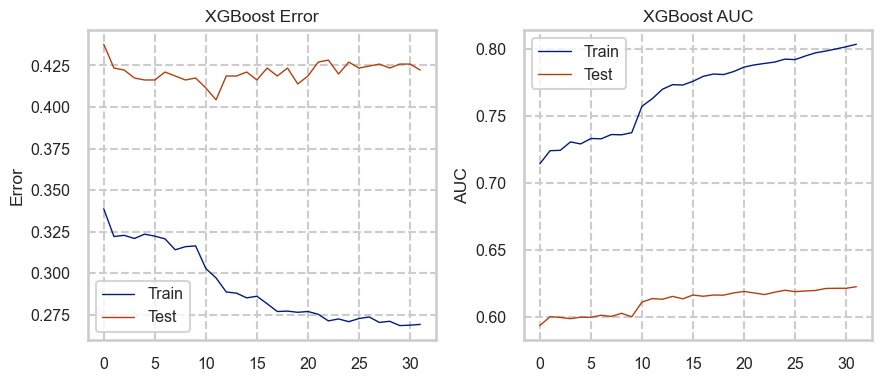

In [32]:
results = model_xgb.evals_result()
x_axis = range(0, len(results['validation_0']['auc']))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax[0].plot(x_axis, results['validation_0']['error'], label='Train')
ax[0].plot(x_axis, results['validation_1']['error'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost Error')
ax[0].set(ylabel='Error')

ax[1].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[1].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[1].legend()
ax[1].set_title('XGBoost AUC')
ax[1].set(ylabel='AUC')

fig.tight_layout()
plt.savefig('earlystopping_xgb_L2.png')

In [33]:
y_train_preds = model_xgb.predict(X_train_tf)
y_valid_preds = model_xgb.predict(X_valid_tf)

In [34]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_preds)
fprt, tprt, thresholds = metrics.roc_curve(y_valid, y_valid_preds)

auc_train, auc_test = metrics.auc(fpr, tpr), metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_valid, y_valid_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_valid, y_valid_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_valid, y_valid_preds)

In [35]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.7028678890456042 0.5812968954360845
Accuracy	 0.7028678890456042 0.5813397129186603
Precission	 0.7103851779619698 0.5579710144927537
Recall		 0.685002350728726 0.5804020100502513
